# Analysis Of Starbucks'  Global Presence


## Research questions

During my visit in the Philippines in 2017 I noticed an increased number of starbucks stores in the country. 
I wonder if this trend expands to the neighboring countries in Asia or Europe. With this we  can ask: 

1. What countries have the most Starbucks locations?  Are there trends we are seeing across the globe?
2. Can we infer from this data how Starbucks choose a country in which to operate?
3. What country currently without Starbucks could be a potential for a new location?



*Importing packages*

In [245]:
import pandas as pd
import numpy as np
import plotly.express as px

* Reading the data into the dataframe
* Preprocessing the data and formatting it

In [363]:
# Data frame for the starbucks locations
starbucks = pd.read_csv('directory.csv')
starbucks['store_count']= np.ones(starbucks.shape[0])
starbucks =starbucks[['Country', 'store_count']]
starbucks=starbucks.groupby('Country').agg({'store_count':'sum'})
starbucks.reset_index(inplace=True)
starbucks.sample(5)


,Country,store_count
44,MA,9.0
65,SV,11.0
62,SE,18.0
40,KW,106.0
56,PR,24.0


In [364]:
#Read the country code file into the dateframe.
country_code = pd.read_csv('country_code.csv')
country_code.sample(2)

#Modify the name of some countries, removing 'the, republic of'
country_name = country_code['Country_Name'].tolist()

country_name = [country.split(',')[0] for country in country_name]

#Assign the modified values in the country_name column
country_code['Country_Name'] = country_name


#Change united states of america to united states
country_code['Country_Name']= country_code['Country_Name'].apply(lambda x : 'United States' if x=='United States of America' else x)

#Change Russian Federation to Russia
country_code['Country_Name']= country_code['Country_Name'].apply(lambda x : 'Russia' if x=='Russian Federation' else x)


country_code['Country_Name']= country_code['Country_Name'].apply(lambda x : 'South Korea' if x=='Korea' else x)

#Change Russian Federation to Russia
country_code['Country_Name']= country_code['Country_Name'].apply(lambda x : 'Czech Republic' if x=='Czech Republic (Czechia)' else x)



In [365]:
#Merge starbucks data frame and country code
starbucks1 = pd.merge(starbucks, country_code, how='outer' ,left_on='Country', right_on='Two_Letter_Country_Code')
starbucks1.drop(['Country'], axis=1, inplace=True)
starbucks1.fillna(0, inplace=True)
starbucks1.sample(4)



,store_count,Continent_Name,Country_Name,Two_Letter_Country_Code
60,11.0,Europe,Portugal,PT
237,0.0,Africa,Tunisia,TN
206,0.0,Asia,Timor-Leste,TL
125,0.0,South America,Falkland Islands,FK


In [366]:
#Dataframe for the world population
world_population = pd.read_csv('world_population.csv')
world_population = world_population[['country', 'population', 'density','land_area']]
world_population['population']= world_population['population'].str.replace(',', '').astype(float)
world_population['density']= world_population['density'].str.replace(',', '').astype(float)
world_population['land_area']= world_population['land_area'].str.replace(',', '').astype(float)

world_population.sample(5)

,country,population,density,land_area
15,DR Congo,89561403.0,40.0,2267050.0
101,Togo,8278724.0,152.0,54390.0
186,Sao Tome & Principe,219159.0,228.0,960.0
116,Congo,5518087.0,16.0,341500.0
183,New Caledonia,285498.0,16.0,18280.0


In [251]:
#DataFrame for the gdp
gdp=pd.read_csv('gdp.csv')

#Merge gdp and world population data frame
gdp_pop = pd.merge(world_population, gdp, how='outer' ,on='country')
gdp_pop.sample(5)
gdp_pop['gdp_per_capita']= gdp_pop.gdp_ppp/gdp_pop.population
gdp_pop= gdp_pop[['country', 'population', 'gdp_per_capita', 'land_area']]
gdp_pop.sample(4)


,country,population,gdp_per_capita,land_area
41,Uzbekistan,33469203.0,7320.162359,425400.0
74,Guinea,13132795.0,2596.794700,245720.0
272,Post-demographic dividend,NaN,NaN,NaN
243,Fragile and conflict affected situations,NaN,NaN,NaN


In [252]:
#Merge starbucks data frame and the gdp_pop data frame
starbucks2 =pd.merge(starbucks1, gdp_pop, how='left', left_on='Country_Name', right_on='country')
starbucks2.sample(5)
starbucks2.dropna(axis=0, inplace=True)
starbucks2.drop('Country_Name',axis=1, inplace=True)
starbucks2.sample(4)

,store_count,Continent_Name,Two_Letter_Country_Code,country,population,gdp_per_capita,land_area
163,0.0,Europe,LV,Latvia,1886198.0,32658.465708,62200.0
229,0.0,South America,SR,Suriname,586632.0,16852.948629,156000.0
206,0.0,Asia,TL,Timor-Leste,1318445.0,3190.068233,14870.0
67,130.0,Asia,SG,Singapore,5850342.0,98797.642941,700.0


In [253]:
#Dataframe for the ease of business
business= pd.read_csv('business_ease.csv')
business= business[['Country Name', 'bus_perf']]

#Merge business data frame with starbucks dataframe
starbucks3= pd.merge(starbucks2, business, how='left', left_on='country', right_on='Country Name')
starbucks3.drop('Country Name', axis=1, inplace=True)
starbucks3.sample(3)


,store_count,Continent_Name,Two_Letter_Country_Code,country,population,gdp_per_capita,land_area,bus_perf
130,0.0,Africa,MU,Mauritius,1271768.0,23828.104149,2030.0,81.46811
105,0.0,Asia,GE,Georgia,3989167.0,14582.982651,69490.0,83.73393
156,0.0,Asia,TJ,Tajikistan,9537645.0,3439.876864,139960.0,61.26761


In [254]:
#Dataframe for the coffee consumption
coffee= pd.read_csv('coffee.csv')
coffee=coffee[['country', 'coffee_consumption']]
coffee.dropna(axis=0, inplace=True)


#Merge the coffee data frame with starbucks
starbucks4= pd.merge(starbucks3, coffee, how='left', on='country')
starbucks4.rename(columns={'Continent_Name':'continent'}, inplace=True)
starbucks4.sample(5)



,store_count,continent,Two_Letter_Country_Code,country,population,gdp_per_capita,land_area,bus_perf,coffee_consumption
105,0.0,Asia,GE,Georgia,3989167.0,14582.982651,69490.0,83.73393,101.0
40,29.0,Asia,LB,Lebanon,6825445.0,15383.612351,10230.0,54.33160,407.0
5,4.0,Asia,AZ,Azerbaijan,10139177.0,14794.100152,82658.0,76.70888,61.0
159,0.0,Oceania,TV,Tuvalu,11792.0,4409.945677,30.0,NaN,NaN
119,0.0,Africa,KE,Kenya,53771296.0,4407.556031,569140.0,73.21648,50.0


In [255]:
def condition(x):
    """
    This function rename continents into regions
    x :  is a string value from a data frame column
    returns a string
    """
    
    if (x=='Europe' or x=='Africa'):
        return f'Europe_Africa'
    elif (x =='Asia' or x =='Oceania'):
        return f'Asia_Oceania'
    else :
        return f'Americas'
    

#Create a new column 'region'  
starbucks4['region']= starbucks4['continent'].apply(lambda x : condition(x))

#Mutate a new column store presence. 
starbucks4['store_presence'] = starbucks4['store_count'].apply(lambda x : 'yes' if x >0  else 'no')

starbucks4.sample(4)


,store_count,continent,Two_Letter_Country_Code,country,population,gdp_per_capita,land_area,bus_perf,coffee_consumption,region,store_presence
26,901.0,Europe,GB,United Kingdom,67886011.0,48021.675629,241930.0,83.54968,2925.0,Europe_Africa,yes
107,0.0,Africa,GH,Ghana,31072940.0,5503.180581,227540.0,59.96017,2.0,Europe_Africa,no
142,0.0,Asia,PK,Pakistan,220892340.0,4798.717783,770880.0,60.95491,311.0,Asia_Oceania,no
108,0.0,Oceania,KI,Kiribati,119449.0,2332.906620,810.0,46.93884,NaN,Asia_Oceania,no


## Research Question 1
### What countries have the most Starbucks locations?Are there trends we are seeing across the globe?

We will use a bar graph to show the top 20 countries in the world that has themost starbucks locations. We will separate them by regions such as Americas(North and South America), Asia and Oceania( Asia and Australia) and Europe and Africa.

* fig.1  Results and Observations

United States  has the most starbucks locations in the world it is follwe by China, Canada, Japan and South Korea.

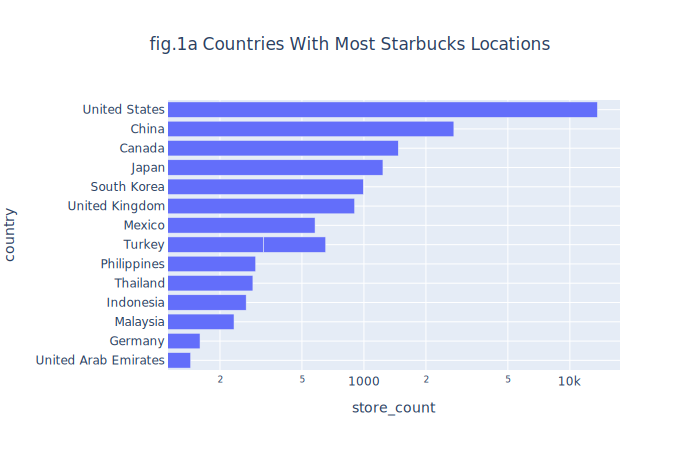

In [370]:
#Create a dataframe with the most starbucks store in the world
store_df = starbucks4[['country', 'store_count']]
store_df = store_df.sort_values('store_count').tail(15)


#Display a bar graph
fig= px.bar(store_df, y='country', x='store_count',
            title='fig.1a Countries With Most Starbucks Locations', log_x=True)

fig.update(layout=dict(title=dict(x=0.5)))
fig.show('svg')


* fig 1b Results and Observations

The graph shows an increased of new stores in Asia every year. There is a decline  of the number of new storesin Americas in 2015 but it starts to pick u again in 2016. Europe has been growing slowly.


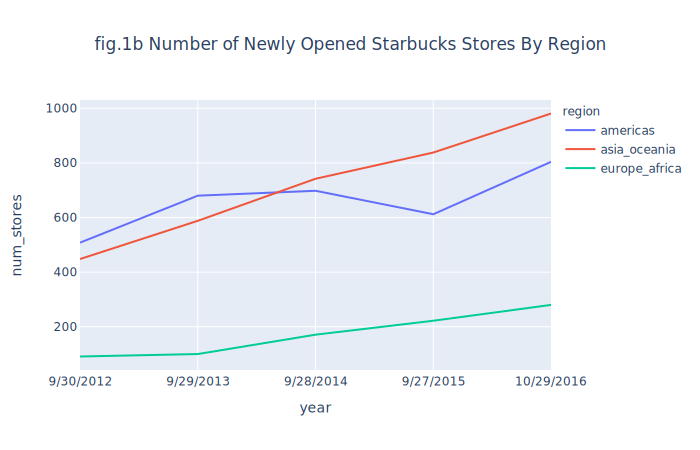

In [371]:
#Display a graph for newly opened starbucks store in 5 years
net_stores= pd.read_csv('starbucks_10k.csv')
net_stores

fig = px.line(net_stores, x='year', y='num_stores', color='region', title='fig.1b Number of Newly Opened Starbucks Stores By Region')

fig.update(layout=dict(title=dict(x=0.5)))
fig.show('svg')

## Research Question 2
### Can we infer from this data how Starbucks chose a country in which to operate?


Gross Domestic Product(GDP) using Purchaisng Power Parity(PPP)

Accroding to wikipidea:

GDP comparisons using PPP are arguably more useful than those using nominal GDP when assessing a nation's domestic market because PPP takes into account the relative cost of local goods, services and inflation rates of the country, rather than using international market exchange rates, which may distort the real differences in per capita income.


Population- data from worldometer

Coffee consumption - data from International Coffee Organization

According to world bank:

Doing Business 2020, a World Bank Group flagship publication, is the 17th in a series of annual studies measuring the regulations that enhance business activity and those that constrain it. Doing Business presents quantitative indicators on business regulations and the protection of property rights that can be compared across 190 economies—from Afghanistan to Zimbabwe—and over time.

Doing Business covers 12 areas of business regulation. Ten of these areas—starting a business, dealing with construction permits, getting electricity, registering property, getting credit, protecting minority investors, paying taxes, trading across borders, enforcing contracts, and resolving insolvency—are included in the ease of doing business score and ease of doing business ranking. Doing Business also measures regulation on employing workers and contracting with the government, which are not included in the ease of doing business score and ranking.

* Results and observations


Countries with  Starbucks stores  has a median GDP per capita of 30000, a median of 17 million people, a median score of 75 on ease of doing business and a median of 610 kg of coffee consumption.


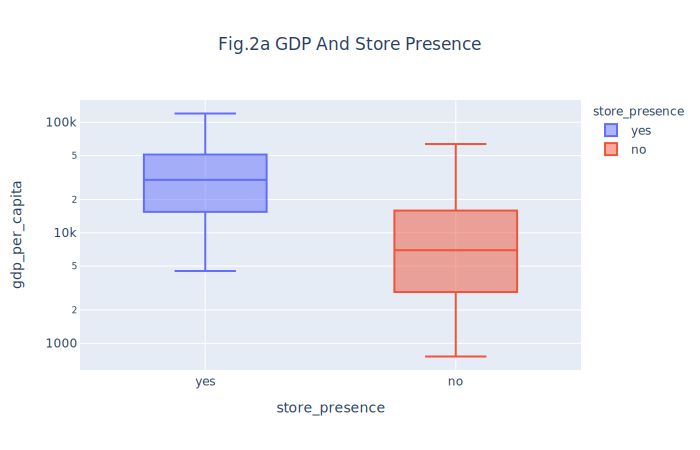

In [372]:

gdp_df = starbucks4[['store_presence', 'gdp_per_capita', 'country', 'region']]

#Display the box plot with gdp per capita and store presence
fig = px.box(gdp_df, x='store_presence', y='gdp_per_capita', color='store_presence',
             points=False, log_y=True, title = "Fig.2a GDP And Store Presence")
             
fig.update(layout=dict(title=dict(x=0.5)))
fig.show('svg')


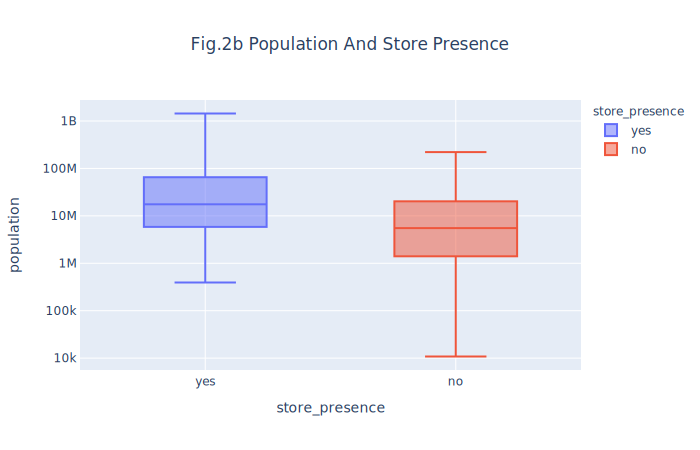

In [373]:
pop_df = starbucks4[['store_presence', 'population','region']].dropna()

#Display the box plot for population and store presence
fig = px.box(pop_df , x='store_presence', y='population', color='store_presence',
             points=False,log_y=True, title = "Fig.2b  Population And Store Presence")
fig.update(layout=dict(title=dict(x=0.5)))
fig.show('svg')

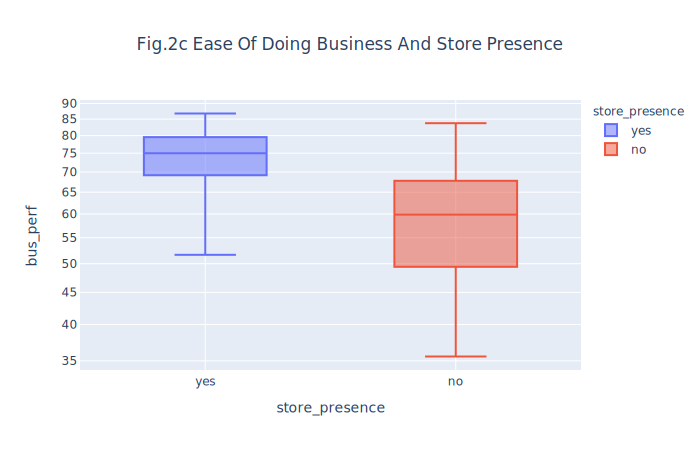

In [374]:
business_df = starbucks4[['store_presence', 'bus_perf','region']]

#Display the box plot for ease of business score and store presence
fig = px.box(business_df , x='store_presence', y='bus_perf', color='store_presence',
             points=False,log_y=True, title = "Fig.2c Ease Of Doing Business And Store Presence")
fig.update(layout=dict(title=dict(x=0.5)))
fig.show('svg')

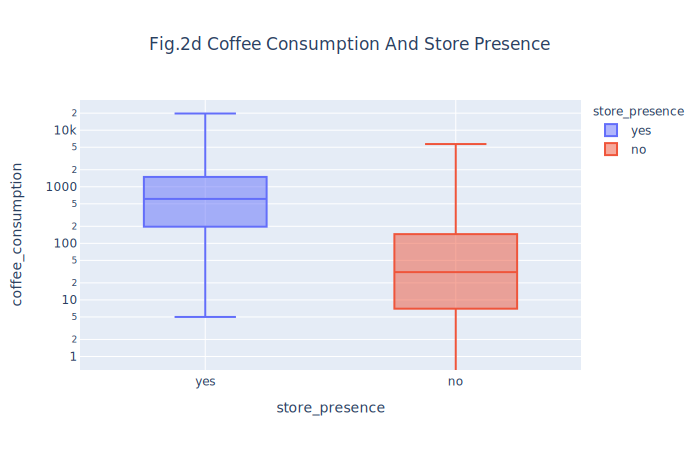

In [375]:
coffee_df = starbucks4[['store_presence', 'coffee_consumption','region']]

#Display the box plot for coffee consumption and store presence
fig = px.box(coffee_df , x='store_presence', y='coffee_consumption', color='store_presence',
             points=False,log_y=True, title = "Fig.2d Coffee Consumption And Store Presence")
fig.update(layout=dict(title=dict(x=0.5)))
fig.show('svg')

## Research Question 3

### What country currently without Starbucks could be a potential for a new location?

* Conclusion:

Italy and Israel aare potential countries to open a new Starbucks locations beause of similar GDP per capita, population, coffe consumption and ease of doing business score to countries that currentaly have Starbucks stores.

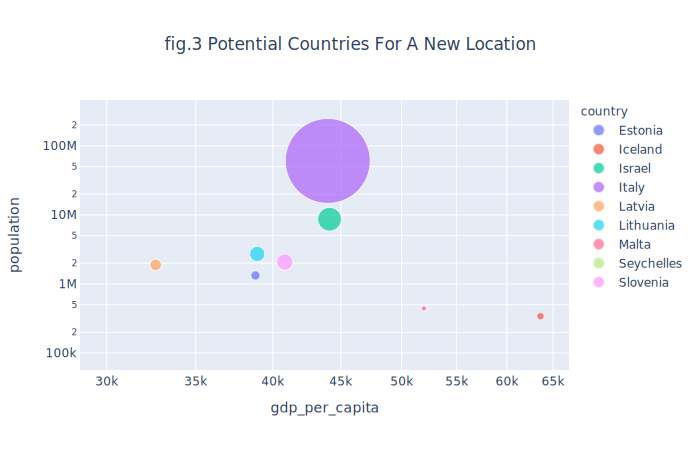

In [376]:
# Create a new datafarme that has countries with no Starbucks stores and higher gdp
open_df=starbucks4.loc[(starbucks4.store_count==0) & (starbucks4.gdp_per_capita>30e3)].dropna()

#Display the graph
fig = px.scatter(open_df, x='gdp_per_capita', y='population', color='country' 
                 , size_max=60, log_y=True, log_x=True, size= 'coffee_consumption', title='fig.3 Potential Countries For A New Location')

fig.update(layout=dict(title=dict(x=0.5)))
fig.show('svg')

                        